In [1]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, modularity



def calculate_modularity(G, communities) :
    mod_value = modularity(G, communities)
    return mod_value


def calculate_coverage(G, communities):
    intra_edges = 0
    total_edges = len(G.edges())
    for community in communities:
        subgraph = G.subgraph(community)
        intra_edges += len(subgraph.edges())
    return intra_edges / total_edges



# Conductance 계산
def calculate_conductance(G, community):
    cut_size = len(list(nx.edge_boundary(G, community)))
    volume = sum([G.degree(n) for n in community])
    return cut_size / min(volume, 2 * len(G.edges()) - volume)


In [1]:
import networkx as nx
import json
import numpy as np
import pandas as pd
from algorithms.borgatti_everett import Borgatti_Everett
from metrics import Metric_Calculator

nodes = pd.read_csv("jean-complete-node.csv")
edges = pd.read_csv("jean-complete-edge.csv")

# 무방향 그래프 생성
G = nx.Graph()

for index, row in nodes.iterrows():
    G.add_node(row['Id'], label=row['Label'], description=row['Description'])

for index, row in edges.iterrows():
    G.add_edge(row['Source'], row['Target'], id=row['Id'], label=row['Label'])

A = nx.to_numpy_array(G)
A = np.where(A != 0, 1, 0)
n = A.shape[0]
model = Borgatti_Everett(G, A, n)
cp_index, cp_metric, cp_cluster = model.fit()
# 그래프를 JSON 형태로 변환하는 함수 (중심성 지표, 위치 및 차수 포함)



def load_gexf_to_graph(gexf_file_path):
    # GEXF 파일을 읽어들임
    graph = nx.read_gexf(gexf_file_path)
    return graph


def graph_overview(G):
    # 중심성 지표 및 노드 차수 계산
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=100)
    degree = dict(G.degree())  # 각 노드의 차수 계산
    
    # 네트워크 전체 통계 계산
    overview = {
        "node_count": G.number_of_nodes(),
        "edge_count": G.number_of_edges(),
        "average_degree": sum(degree.values()) / float(G.number_of_nodes()),
        "density": nx.density(G),
        "average_clustering_coefficient": nx.average_clustering(G),
        "average_shortest_path_length": nx.average_shortest_path_length(G) if nx.is_connected(G) else None,
        "degree_centrality_max": max(degree_centrality.values()),
        "degree_centrality_avg": sum(degree_centrality.values()) / len(degree_centrality),
        "betweenness_centrality_max": max(betweenness_centrality.values()),
        "betweenness_centrality_avg": sum(betweenness_centrality.values()) / len(betweenness_centrality),
        "closeness_centrality_max": max(closeness_centrality.values()),
        "closeness_centrality_avg": sum(closeness_centrality.values()) / len(closeness_centrality),
        "eigenvector_centrality_max": max(eigenvector_centrality.values()),
        "eigenvector_centrality_avg": sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
    }
    # JSON 파일로 저장
    with open('./graph_data_overview.json', 'w') as json_file:
        json.dump(overview, json_file, indent=4)

def graph_node_edge(G, model):
    # spring layout 사용하여 노드의 위치 계산
    pos = nx.spring_layout(G)
    cp_index, cp_metric, cp_cluster = model.fit()

    # 중심성 지표 및 노드 차수 계산
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=100)
    degree = dict(G.degree())  # 각 노드의 차수 계산

    # 노드 리스트 생성 (key, 위치, 중심성 지표, 차수 포함)
    nodes = [
        {
            "id": n,
            "key": n,
            "label": data.get('label', n),
            "x": pos[n][0],
            "y": pos[n][1],
            "degree": degree[n],  # 노드 차수 추가
            "degree_centrality": degree_centrality[n],
            "betweenness_centrality": betweenness_centrality[n],
            "closeness_centrality": closeness_centrality[n],
            "eigenvector_centrality": eigenvector_centrality[n],
            "core_periphery": float(cp_index[list(G.nodes).index(n)]),
            "attributes": data  # 노드의 모든 속성 포함
        } 
        for n, data in G.nodes(data=True)
    ]
    
    # 엣지 리스트 생성 (가중치 포함)
    edges = [
        {
            "source":u,  # source를 노드 라벨로 변경
            "target":v,  # target을 노드 라벨로 변경
            "weight": data.get("weight", 1.0),
            "attributes": data  # 엣지의 모든 속성 포함
        } 
        for u, v, data in G.edges(data=True)
    ]

    graph_json = {"nodes": nodes, "edges": edges}
    
    with open('./graph_data.json', 'w') as json_file:
        json.dump(graph_json, json_file, indent=4)

def graph_adjacency(G, cp_index):
    # Identify core and periphery nodes based on cp_index
    core_nodes = [i for i, x in enumerate(cp_index) if x >= 0.5]
    periphery_nodes = [i for i, x in enumerate(cp_index) if x < 0.5]

    core = [1 for i,x in enumerate(cp_index) if x >= 0.5]
    peri = [0 for i,x in enumerate(cp_index) if x < 0.5]
    # Combined new order
    new_order = core_nodes + periphery_nodes
    cp_ind = core + peri

    # Reorder the adjacency matrix
    A = nx.to_numpy_array(G)
    A_reordered = A[new_order, :][:, new_order]

    # Generate node labels, using 'label' attribute if it exists, otherwise the node ID
    nodes_ordered_labels = [
        G.nodes[i].get("label", i) for i in [list(G.nodes)[j] for j in new_order]
    ]

    # Convert the reordered adjacency matrix to a list of lists for JSON serialization
    A_reordered_list = A_reordered.tolist()

    # Combine node labels and adjacency matrix into a dictionary
    adj_info = {"nodes_labels": nodes_ordered_labels, "cp_ind": cp_ind, "adjacency": A_reordered_list}

    # Write the information to a JSON file
    with open('./graph_data_adjacency.json', 'w') as json_file:
        json.dump(adj_info, json_file, indent=4)

/Users/jeongjin/miniconda3/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [5]:
# GEXF 파일 경로
gexf_file_path = 'LesMiserables.gexf'
# GEXF 파일을 그래프로 로드
graph = load_gexf_to_graph(gexf_file_path)

A = nx.to_numpy_array(graph)
A = np.where(A != 0, 1, 0)
n = A.shape[0]
model = Borgatti_Everett(graph, A, n)
cp_index, cp_metric, cp_cluster = model.fit()

graph_overview(graph)
graph_node_edge(graph, model)
graph_adjacency(graph, cp_index)

get_metrics = Metric_Calculator(graph, cp_index)


print(get_metrics.borgatti_everett_correlation())
print(get_metrics.brusco_metric()/np.sum(A))
print(get_metrics.calculate_core_quality()/np.sum(A))
print(get_metrics.get_core_periphery_probabilities())

0.20528390734531207
4.505905511811024
0.39763779527559057
(0.7619047619047619, 0.22040816326530613, 0.053830227743271224)


In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# GEXF 파일을 읽어들여 NetworkX 그래프로 변환



A = nx.to_numpy_array(graph)
n = A.shape[0]
model = Borgatti_Everett(graph, A, n)
graph_json = graph_to_json_with_centrality_positions_and_degree(graph, model)

with open('./graph_data_les.json', 'w') as json_file:
    json.dump(graph_json, json_file, indent=4)

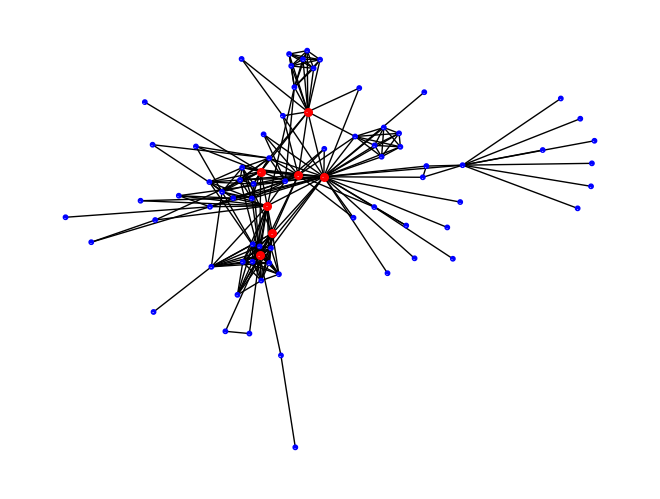

In [15]:
def plot_core_periphery_graph(G, core_indices):
    # Get the node labels (strings) from the graph using the indices
    core_nodes = [list(G.nodes)[i] for i in core_indices]
    
    # Set node color: 'red' for core nodes and 'blue' for periphery nodes
    node_colors = ['red' if node in core_nodes else 'blue' for node in G.nodes]
    
    # Draw the graph
    pos = nx.spring_layout(G)  # spring layout for better visualization
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=10, font_size=0, font_color='white')
    
    # Highlight core nodes with larger size
    nx.draw_networkx_nodes(G, pos, nodelist=core_nodes, node_color='red', node_size=30)
    plt.show()

best_core_indices_borgatti = [i for i, gene in enumerate(cp_index) if gene > 0.5]
plot_core_periphery_graph(graph, best_core_indices_borgatti)

In [11]:
cp_metric

0.34280450277827745

In [2]:
cp_index

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1])

In [9]:
import numpy as np

# Reorder the nodes based on cp_index
core_nodes = [i for i, x in enumerate(cp_index) if x >= 0.5]
periphery_nodes = [i for i, x in enumerate(cp_index) if x < 0.5]

# Combined new order
new_order = core_nodes + periphery_nodes

# Reorder the adjacency matrix
A_reordered = A[new_order, :][:, new_order]

# Convert the reordered adjacency matrix back to a DataFrame for better readability
nodes_ordered_labels = [list(G.nodes)[i] for i in new_order]
A_reordered_df = pd.DataFrame(A_reordered, index=nodes_ordered_labels, columns=nodes_ordered_labels)


In [10]:
core_nodes

[0,
 25,
 35,
 40,
 46,
 47,
 78,
 80,
 82,
 105,
 109,
 123,
 134,
 144,
 160,
 164,
 169,
 180]

In [11]:
nodes_ordered_labels

['TH',
 'GA',
 'FN',
 'FE',
 'EP',
 'EN',
 'CR',
 'CO',
 'CM',
 'BO',
 'BJ',
 'MY',
 'MM',
 'MA',
 'JV',
 'JO',
 'JA',
 'TM',
 'TG',
 'TE',
 'TC',
 'GV',
 'GU',
 'GT',
 'GS',
 'GR',
 'GP',
 'GN',
 'SW',
 'GL',
 'GI',
 'SS',
 'SR',
 'GG',
 'GF',
 'SP',
 'GE',
 'SO',
 'GD',
 'SN',
 'SM',
 'GB',
 'SI',
 'SG',
 'SF',
 'SE',
 'SD',
 'SC',
 'SB',
 'FV',
 'FT',
 'FM',
 'FL',
 'FF',
 'RP',
 'FD',
 'RM',
 'FB',
 'FA',
 'RA',
 'QU',
 'DV',
 'DU',
 'DS',
 'DR',
 'PZ',
 'DO',
 'DN',
 'DM',
 'DJ',
 'PT',
 'PS',
 'DH',
 'DG',
 'PR',
 'PO',
 'PN',
 'DA',
 'PL',
 'PH',
 'PG',
 'CZ',
 'CY',
 'PE',
 'CX',
 'PD',
 'CW',
 'PC',
 'CV',
 'PA',
 'CP',
 'CN',
 'CL',
 'CK',
 'CJ',
 'CI',
 'CH',
 'OS',
 'CG',
 'CF',
 'CE',
 'CD',
 'CC',
 'CB',
 'CA',
 'BZ',
 'BY',
 'BX',
 'BW',
 'BU',
 'BT',
 'BS',
 'BR',
 'BQ',
 'BM',
 'BL',
 'BK',
 'BI',
 'NT',
 'BH',
 'BG',
 'BF',
 'NP',
 'BC',
 'BB',
 'BA',
 'NI',
 'AZ',
 'NV',
 'ZE',
 'AM',
 'MW',
 'MV',
 'MU',
 'MT',
 'MS',
 'MR',
 'MP',
 'MO',
 'MN',
 'AA',
 'ML',
 'MI',

In [6]:
A_reordered

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
A_reordered_df

,TH,GA,FN,FE,EP,EN,CR,CO,CM,BO,...,VI,IW,VB,IS,IK,ID,HL,TS,TR,HD
TH,0,1,1,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
GA,1,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
FN,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
FE,0,1,0,0,0,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
EP,1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HL,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TS,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
TR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
